## Pre-request

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
train = pd.read_csv('./data/data.csv')

## 简单空值填充

In [4]:
# clean data
train = pd.read_csv('./data/data.csv') # 训练集的读取
train1 = train
train1=train1.fillna(train1.mean())
train1=train1.fillna('None') 
print('train set is filled with mean/none, sum NA=', sum(train1.isnull().sum()))

# build train set
y = train1['SalePrice']
train1 = train1.drop(['Id', 'SalePrice'], axis=1)
X=pd.get_dummies(train1) # Convert categorical variable into dummy/indicator variables

# train the model 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
print('set is splited into train, test:', X_train.shape, X_test.shape)
xg_reg = xgb.XGBRegressor(objective='reg:linear',
                          colsample_bytree=0.6,
                          learning_rate=0.01,
                          max_depth=8,
                          alpha=10,
                          n_estimators=700,
                          subsample=0.7,
                          random_state=123)
xg_reg.fit(X_train,y_train)

# model valuation 
pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
logrmse = np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
print('rmse:', rmse, 'logrmse:', logrmse)

train set is filled with mean/none, sum NA= 0
set is splited into train, test: (1168, 303) (292, 303)
rmse: 24348.483575624807 logrmse: 0.11327867840739252


## XGB交叉验证

1.数据有限->发挥数据本来的效率

2.数据的训练集和评测集的矛盾

    如果用更多的数据去训练，那么就会有更少的数据来评测->失去了对于真实泛化能力的考量
    
    如果用更少的数据来训练，很大可能造成欠拟合，在评测集上表现就一定不好
    
解决方法：

1.将数据集拆成K份->(首先进行shuffle)

2.规定k-1份进行训练，剩下的1份进行评测，总共训练k次，轮流每个子数据集作为评测集

    数据集被分成K份，1......K
    
    第一次训练使用第1份数据集作为评测集，剩余的k-1份作为训练集
    
    第i次训练使用第i份数据集作为评测集，剩余的k-1份作为训练集
    
    做k次训练
    
3.k次训练之后，评测的分值=k次评测结果的平均

4.不同的模型会提供不同的子模型的合并方法，会将所有的k个子模型进行合并



In [5]:
params = {"objective":"reg:linear",
          'colsample_bytree': 0.7,
          'learning_rate': 0.1,
          'max_depth': 5, 
          'alpha': 10}

train = pd.read_csv('./data/data.csv') # 训练集的读取
train1 = train

y = train1['SalePrice']
X=pd.get_dummies(train1.drop(['Id', 'SalePrice'], axis=1)) # Convert categorical variable into dummy/indicator variables
matrix=xgb.DMatrix(data=X,label=y)

cv_results = xgb.cv(dtrain=matrix, params=params,
                    nfold = 5,  
                    num_boost_round=1, 
                    metrics = 'rmse',
                    as_pandas=True)

[20:34:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[20:34:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[20:34:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[20:34:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[20:34:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5


In [6]:
def getnullcount():
    x=train.isnull().sum()
    print(x[x>0])
    x[x>0].sort_values().plot.bar()

## EDA 与空值填充

In [7]:
train = pd.read_csv('./data/data.csv') # 训练集的读取
train1 = train

train['SqrtLotArea']=np.sqrt(train['LotArea'])
filter=train['LotFrontage'].isnull()
train.LotFrontage[filter]=0.6*train.SqrtLotArea[filter]

filter=train['MasVnrArea'].isnull()
train.MasVnrArea[filter]=0.0

filter=train['MasVnrType'].isnull()
train.MasVnrType[filter]='None'

filter=train['Electrical'].isnull()
train['Electrical'][filter]='SBrkr'

train['Alley']=train['Alley'].fillna('None')

basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']
train[train.BsmtCond=='NA']
for col in basement_cols:
    if 'FinSF' not in col:
        train[col]=train[col].fillna('None')
#getnullcount()

train['FireplaceQu']=train['FireplaceQu'].fillna('None')
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']        
        
for col in garage_cols:
    if train[col].dtype==np.object:
        train[col]=train[col].fillna('None')
    else:
        train[col]=train[col].fillna(0)        


        
train.PoolQC=train.PoolQC.fillna('None')
train['Fence']=train['Fence'].fillna('None')
train['MiscFeature']=train['MiscFeature'].fillna('None')

train.to_csv('./data/train_1.csv')

## 数据集的准备

In [8]:
train = pd.read_csv('./data/train_1.csv')
train1 = train.drop(['Id','SalePrice'], axis=1)

X = pd.get_dummies(train1).reset_index(drop=True)
#X = X.drop('Unnamed: 0', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)



lm = LinearRegression()
p = lm.fit(X_train, y_train)
pred = p.predict(X_test)
print(np.sqrt(mean_squared_error(np.log(y_test), np.log(pred))))
print(np.sqrt(mean_squared_error(y_test,pred)))

def benchmark(model):
    pred=model.predict(X_test)
    logrmse=np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
    return logrmse

print(benchmark(p))
print(benchmark(lm))

0.12618361140973064
24966.337410199685
0.12618361140973064
0.12618361140973064


## 数据预处理

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

lm_model=make_pipeline(RobustScaler(),LinearRegression())
lm_model.fit(X_train, y_train)
benchmark(lm_model)

0.12618361141005302

## 朴素的Ridge回归

In [10]:
from sklearn.linear_model import Ridge
ridge_model=Ridge(alpha=0.1)
ridge_model.fit(X_train,y_train)
benchmark(ridge_model)

0.126556520037331

## 带有RobustScaler的回归

In [11]:
ridge_model_pipe=make_pipeline(RobustScaler(),Ridge(alpha=0.1))
ridge_model_pipe.fit(X_train,y_train)
benchmark(ridge_model_pipe)

0.12655937132758466

In [12]:
def benchmark1(model,testset,label):
    pred=model.predict(testset)
    if pred[pred<0].shape[0]>0:
        print('Neg Value')
    rmse=np.sqrt(mean_squared_error(label,pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(pred)))

    print('RMSE:',rmse)
    print('LRMSE:',lrmse)
    return lrmse

## 带有CV的回归

In [13]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV

kfolds=KFold(n_splits=10,shuffle=True,random_state=123)

r_alphas=[0.01,0.1,1,3,5,7,10,100]

ridge_model_cv=make_pipeline(RobustScaler(),RidgeCV(alphas=r_alphas,cv=kfolds))

ridge_model_cv.fit(X_train,y_train)

benchmark1(ridge_model_cv,X_test,y_test)
benchmark(ridge_model_cv)

RMSE: 26917.45795604977
LRMSE: 0.12438552197375952


0.12438552197375952

RMSE: 24966.403023664658
LRMSE: 0.126184681336755
RMSE: 24966.534049511727
LRMSE: 0.12618679131149577
RMSE: 24966.6648171022
LRMSE: 0.12618886217756353
RMSE: 24966.79533984039
LRMSE: 0.12619089480006948
RMSE: 24966.92563088885
LRMSE: 0.1261928900227457
RMSE: 24972.815984081975
LRMSE: 0.12625505551667762
RMSE: 25007.89344047133
LRMSE: 0.12636426623738942
RMSE: 25070.760495434526
LRMSE: 0.12655937132758466
RMSE: 25331.381365950743
LRMSE: 0.12765621823283263
RMSE: 25785.94019059843
LRMSE: 0.1300500271901627
RMSE: 26033.309156661973
LRMSE: 0.13164569772057505
RMSE: 26021.284156113066
LRMSE: 0.1315083195428357
RMSE: 25912.005959014128
LRMSE: 0.13040651460413405
RMSE: 25851.247191696213
LRMSE: 0.12942505856751374
RMSE: 25837.650296852436
LRMSE: 0.12863398298618786
RMSE: 25894.215804064745
LRMSE: 0.1274375802593777
RMSE: 26148.054001323075
LRMSE: 0.12591254743971536
RMSE: 26299.322251440426
LRMSE: 0.12541103327969802
RMSE: 26454.85537465425
LRMSE: 0.12502851180211802
RMSE: 26610.910893761204


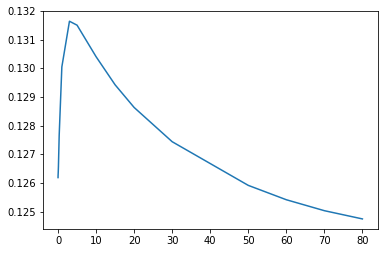

In [14]:
r_alphas=[.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

def ridge_train_test(alpha):
    m=make_pipeline(RobustScaler(),RidgeCV(alphas=[alpha],cv=kfolds))
    m.fit(X_train,y_train)
    return benchmark1(m,X_test,y_test)

scores=[]
for k in r_alphas:
    scores.append(ridge_train_test(k))
plt.plot(r_alphas,scores)

## RidgeCV auto para

RMSE: 24966.276878819317
LRMSE: 0.12618290322343118
RMSE: 24966.22902447246
LRMSE: 0.12618316230185925
RMSE: 24966.253324447316
LRMSE: 0.12618301743461227
RMSE: 24966.199795231787
LRMSE: 0.1261831694951341
RMSE: 24966.280027362485
LRMSE: 0.12618330041409337
RMSE: 24966.243031190723
LRMSE: 0.12618319810345294
RMSE: 24966.260864683616
LRMSE: 0.12618332230063534
RMSE: 24966.275474539252
LRMSE: 0.1261833960419615
RMSE: 24966.318712473105
LRMSE: 0.12618352852236908
RMSE: 24966.283203885185
LRMSE: 0.1261834478144912
RMSE: 24966.33172052313
LRMSE: 0.12618354383995475
RMSE: 24966.33193560825
LRMSE: 0.126183550637206
RMSE: 24966.339818303462
LRMSE: 0.12618355874143436
RMSE: 24966.324485959274
LRMSE: 0.12618355372065473
RMSE: 24966.335781383394
LRMSE: 0.12618357613444758
RMSE: 24966.32618541658
LRMSE: 0.12618355579162346
RMSE: 24966.33161091169
LRMSE: 0.12618357667538305
RMSE: 24966.33168244294
LRMSE: 0.12618358412987105
RMSE: 24966.334621407084
LRMSE: 0.1261835925015364
RMSE: 24966.330849547936

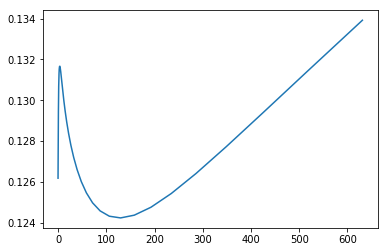

In [21]:
r_alpha2 = np.logspace(-10, 2.8, 150) # 10^-10 ~ 2 

scores = [] 
for k in r_alpha2:
    scores.append(ridge_train_test(k))
plt.plot(r_alpha2, scores)

we can use auto scanning for best alpha

In [22]:
ridge_model2 = make_pipeline(RobustScaler(), RidgeCV(
                alphas=r_alpha2, cv=kfolds)).fit(X_train, y_train)

In [23]:
benchmark1(ridge_model2, X_test, y_test)

# best alpha
ridge_model2.steps[1][1].alpha_

RMSE: 26002.568196719014
LRMSE: 0.12660125085842486


0.12660125085842486

## Lasso

In [25]:
from sklearn.linear_model import LassoCV

Alpha: 1e-10
RMSE: 24903.67416108695
LRMSE: 0.1266018506534091
Alpha: 1.2187258987140784e-10
RMSE: 24903.67416148097
LRMSE: 0.12660185065387594
Alpha: 1.4852928161964384e-10
RMSE: 24903.674161961204
LRMSE: 0.12660185065444526
Alpha: 1.810164822272569e-10
RMSE: 24903.67416254646
LRMSE: 0.12660185065513913
Alpha: 2.206094749844747e-10
RMSE: 24903.6741632597
LRMSE: 0.12660185065598456
Alpha: 2.6886248066529384e-10
RMSE: 24903.674164128963
LRMSE: 0.12660185065701476
Alpha: 3.2766966837930683e-10
RMSE: 24903.674165188386
LRMSE: 0.1266018506582705
Alpha: 3.993395110769148e-10
RMSE: 24903.674166479497
LRMSE: 0.12660185065980104
Alpha: 4.866854045292537e-10
RMSE: 24903.674168053032
LRMSE: 0.1266018506616664
Alpha: 5.931361070259395e-10
RMSE: 24903.67416997074
LRMSE: 0.12660185066393959
Alpha: 7.22870335094958e-10
RMSE: 24903.674172307914
LRMSE: 0.12660185066670998
Alpha: 8.809807987923498e-10
RMSE: 24903.674175156266
LRMSE: 0.12660185067008645
Alpha: 1.0736741157580489e-09
RMSE: 24903.67417862

RMSE: 24879.822731776723
LRMSE: 0.12640505071568056
Alpha: 0.07052159847396076
RMSE: 24873.935625104623
LRMSE: 0.12636368606451517
Alpha: 0.08594649847893122
RMSE: 24866.502421138222
LRMSE: 0.12630915716993407
Alpha: 0.10474522360006364
RMSE: 24857.502012760608
LRMSE: 0.12624520275462495
Alpha: 0.12765571676799467
RMSE: 24846.528552704283
LRMSE: 0.12616987355034356
Alpha: 0.15557732814406416
RMSE: 24833.422787385127
LRMSE: 0.12606066989193118
Alpha: 0.1896061190619089
RMSE: 24822.70671726137
LRMSE: 0.12597391712539543
Alpha: 0.23107788785541353
RMSE: 24815.056947512774
LRMSE: 0.12591309797664424
Alpha: 0.2816206065495399
RMSE: 24813.01765902975
LRMSE: 0.12588767502445217
Alpha: 0.3432183268134919
RMSE: 24810.81192942417
LRMSE: 0.12585259350290368
Alpha: 0.4182890638009153
RMSE: 24807.609702080983
LRMSE: 0.12582893088724115
Alpha: 0.509779715203041
RMSE: 24805.024226877147
LRMSE: 0.12580453496256655
Alpha: 0.6212817415570331
RMSE: 24802.251860401324
LRMSE: 0.1257846814296391
Alpha: 0.75

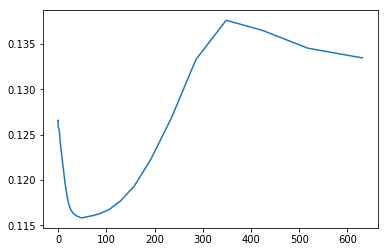

In [40]:
l_alphas = np.logspace(-10, 2.8, 150)

def lasso_train_test(alpha):
    lasso_model = make_pipeline(RobustScaler(), LassoCV(alphas=[alpha], cv=kfolds))
    lasso_model.fit(X_train, y_train)
    lrmse=benchmark1(lasso_model, X_test, y_test)
    return lrmse

scores = [] 

for k in l_alphas:
    print('Alpha:', k)
    scores.append(lasso_train_test(k))

lasso_train_test(50)
plt.plot(l_alphas, scores)

In [45]:
lasso_model2 = make_pipeline(RobustScaler(), LassoCV(
    alphas=l_alphas, cv=kfolds)).fit(X_train, y_train)

benchmark1(lasso_model2, X_test, y_test)
lasso_model2.steps[1][1].alpha_

RMSE: 25439.746569821076
LRMSE: 0.12228974592716883


192.5589718453296

## ElasticNet

$1 / (2 * n_samples) * ||y - Xw||^2_2
+ alpha * l1_ratio * ||w||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2$

In [58]:
from sklearn.linear_model import ElasticNetCV
l1ratio=[.1,.2,.3,.4,.5,.6,.7,.8,.85,.9,.95,1]
e_alphas = l_alphas

def elastic_train_test(alpha, l1ratio):
    e_model = make_pipeline(RobustScaler(), ElasticNetCV(
    alphas=[alpha], l1_ratio=[l1ratio]))
    e_model.fit(X_train, y_train)
    lrmse = benchmark1(e_model, X_test, y_test)
    return lrmse

elastic_train_test(50, .5)

RMSE: 64802.77270461465
LRMSE: 0.3056722083417286


0.3056722083417286

In [59]:
elastic_model3 = make_pipeline(RobustScaler(), ElasticNetCV(
    alphas=e_alphas, l1_ratio=l1ratio)).fit(X_test, y_test)

In [60]:
benchmark1(elastic_model3, X_test, y_test)

RMSE: 18630.38463663732
LRMSE: 0.0942455507712678


0.0942455507712678

In [62]:
elastic_model3.steps[1][1].alpha_

0.7571721488337431

In [63]:
elastic_model3.steps[1][1].l1_ratio_

0.95

In [64]:
from numpy import *

In [69]:
v1 = mat([12,34,5,6,17,8])
v2 = mat([21,3,114,12,4,5])

In [67]:
v1 = mat([1,2,3])
v2 = mat([4,5,6])

In [79]:
sqrt((v1-v2)*(v1-v2).T)

sum(abs(v1-v2))

dot(v1,v2.T) / (linalg.norm(v1) * linalg.norm(v2))

matrix([[0.22840195]])